# Spark SQL and Classification on Car Evaluation Dataset

The following exercise demonstrates loading and preprocessing car evaluation data. The dataset comprises four classes describing car conditions (unacceptable, acceptable, good, very good). 

Three machine learning algorithms (Decision Tree, Random Forest, Multilayer Perceptrons) are applied to determine the best model for classification.

In [1]:
from pyspark.sql import SQLContext, Row
sqlContext = SQLContext(sc)

In [2]:
!rm car.data -f
!wget http://archive.ics.uci.edu/ml/machine-learning-databases/car/car.data

--2017-03-23 21:36:19--  http://archive.ics.uci.edu/ml/machine-learning-databases/car/car.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.249
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.249|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 51867 (51K) [text/plain]
Saving to: ‘car.data’

100%[======================================>] 51,867      --.-K/s   in 0.06s   

2017-03-23 21:36:20 (784 KB/s) - ‘car.data’ saved [51867/51867]



In [3]:
!ls
data = sc.textFile("car.data")

car.data    dataset_Facebook.csv  README.md		  StockPrices.csv
car.data.1  OnlineRetail.csv.gz   sample_libsvm_data.txt  world_bank.json.gz


In [4]:
data.take(10)

[u'vhigh,vhigh,2,2,small,low,unacc',
 u'vhigh,vhigh,2,2,small,med,unacc',
 u'vhigh,vhigh,2,2,small,high,unacc',
 u'vhigh,vhigh,2,2,med,low,unacc',
 u'vhigh,vhigh,2,2,med,med,unacc',
 u'vhigh,vhigh,2,2,med,high,unacc',
 u'vhigh,vhigh,2,2,big,low,unacc',
 u'vhigh,vhigh,2,2,big,med,unacc',
 u'vhigh,vhigh,2,2,big,high,unacc',
 u'vhigh,vhigh,2,4,small,low,unacc']

In [5]:
# separate each line into list
content = data.map(lambda x: x.split(","))
content.take(2)

[[u'vhigh', u'vhigh', u'2', u'2', u'small', u'low', u'unacc'],
 [u'vhigh', u'vhigh', u'2', u'2', u'small', u'med', u'unacc']]

Convert the features to integers. For instance, since there are 4 classes that indicate car condition, we want to convert the string to integer: 'unacc' = 0, 'acc' = 1, 'good' = 2, and 'vgood' = 3.

In [6]:
import re

def convert_to_int(line):
    new_line = []
    for y in line:
        if y == 'unacc':
            y = int(0)
        elif y == 'acc':
            y = int(1)
        elif y == 'good':
            y = int(2)
        elif y == 'vgood':
            y = int(3)
        elif y == 'vhigh':
            y = int(3)
        elif y == 'high':
            y = int(2)
        elif y == 'med':
            y = int(1)
        elif y == 'low':
            y = int(0)
        elif y == 'small':
            y = int(0)
        elif y == 'big':
            y = int(2)
        elif y == '5more':
            y = int(5)
        elif y == 'more':
            y = int(5)
        elif y == '2':
            y = int(2)
        elif y == '3':
            y = int(3)
        elif y == '4':
            y = int(4)
        new_line.append(y)
    return new_line
        
        
content_new = content.map(lambda x: convert_to_int(x))
content_new.take(3)

[[3, 3, 2, 2, 0, 0, 0], [3, 3, 2, 2, 0, 1, 0], [3, 3, 2, 2, 0, 2, 0]]

In [7]:
# Map the RDD to SQL
sql_data = content_new.map(lambda x: Row(buying=x[0], \
           maint=x[1], doors=x[2], persons=x[3], \
           lug_boot=x[4], safety=x[5], y_label=x[6]))
sql_df = sqlContext.createDataFrame(sql_data)
sql_df.registerTempTable("carData")


Show the first 10 cars with very good condition (y_label = 3)

In [8]:
sqlContext.sql("SELECT * FROM carData ORDER BY y_label desc limit 10").toPandas()

,buying,doors,lug_boot,maint,persons,safety,y_label
0,1,4,1,1,5,2,3
1,1,3,1,1,5,2,3
2,1,4,2,1,4,2,3
3,1,2,2,1,5,2,3
4,1,3,2,1,4,2,3
5,1,3,2,1,5,2,3
6,1,4,1,1,4,2,3
7,1,2,2,1,4,2,3
8,1,5,1,1,4,2,3
9,1,4,2,1,5,2,3


Here we see that the top 10 cars with very good condition were initially bought with medium price, had medium or big luggage space, had medium maintainence cost, could fit 4 or more people, and scored high in safety.

In [9]:
sqlContext.sql("SELECT * FROM carData ORDER BY y_label asc limit 10").toPandas()

,buying,doors,lug_boot,maint,persons,safety,y_label
0,3,2,0,3,2,0,0
1,3,2,0,3,2,1,0
2,3,2,0,3,2,2,0
3,3,2,1,3,2,0,0
4,3,2,1,3,2,1,0
5,3,2,1,3,2,2,0
6,3,2,2,3,2,0,0
7,3,2,2,3,2,1,0
8,3,2,2,3,2,2,0
9,3,2,0,3,4,0,0


From the 10 cars with unacceptable condition, we can see that they were bought with very high price, had 2 doors, had very high maintainence cost, while their luggage space, number of people that they could fit, and safety score vary.

In [10]:
query = "SELECT y_label, count(*) as yCount FROM carData GROUP BY y_label ORDER BY y_label desc"
df = sqlContext.sql(query).toPandas()
print df

   y_label  yCount
0        3      65
1        2      69
2        1     384
3        0    1210


The number of cars in unacceptable condition is most common, while those in very good condition is the rarest.

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt, numpy as np


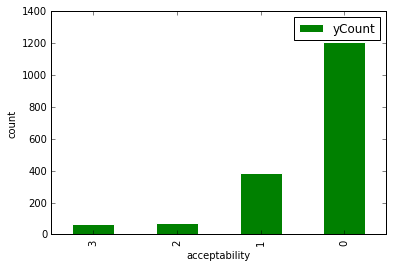

In [12]:
ax = df.plot(kind='bar', x='y_label', y='yCount', color='green',\
                 edgecolor='w')
ax.set_xlabel("acceptability")
ax.set_ylabel("count")

# Classification

### Classify using decision tree

In [13]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorIndexer, VectorAssembler
from pyspark.mllib.util import MLUtils

# create index for labels (ex. 0.0, 1.0, 3.0)
labelIndexer = StringIndexer(inputCol="y_label", outputCol="label").fit(sql_df).transform(sql_df)

# assemble all feature columns into one column
feats = ["buying", "doors", "lug_boot", "persons", "maint"]
assembler = VectorAssembler(inputCols=feats, outputCol="features").transform(labelIndexer)
assembler.take(2)

[Row(buying=3, doors=2, lug_boot=0, maint=3, persons=2, safety=0, y_label=0, label=0.0, features=DenseVector([3.0, 2.0, 0.0, 2.0, 3.0])),
 Row(buying=3, doors=2, lug_boot=0, maint=3, persons=2, safety=1, y_label=0, label=0.0, features=DenseVector([3.0, 2.0, 0.0, 2.0, 3.0]))]

In [14]:
# select only the label and features columns
assm_feats_label = assembler.select(["features", "label"])

# split the dataset into training and test
trainval_df, test_df = assm_feats_label.randomSplit([0.7, 0.3])

# split the training set into train and validation set
train_df, val_df = trainval_df.randomSplit([0.5, 0.5])
train_df.take(2)

[Row(features=DenseVector([3.0, 2.0, 0.0, 2.0, 3.0]), label=0.0),
 Row(features=DenseVector([3.0, 2.0, 1.0, 2.0, 3.0]), label=0.0)]

In [15]:
# train a decision tree model
dt = DecisionTreeClassifier(labelCol="label", featuresCol="features")

# train model
model = dt.fit(train_df)

In [16]:
# make prediction on val dataset
pred_val = model.transform(val_df)

pred_val.select("prediction", "label", "features").show(5)

+----------+-----+--------------------+
|prediction|label|            features|
+----------+-----+--------------------+
|       0.0|  0.0|[3.0,2.0,0.0,2.0,...|
|       0.0|  0.0|[3.0,2.0,2.0,2.0,...|
|       0.0|  0.0|[3.0,2.0,2.0,2.0,...|
|       0.0|  0.0|[3.0,3.0,0.0,2.0,...|
|       0.0|  0.0|[3.0,3.0,0.0,2.0,...|
+----------+-----+--------------------+
only showing top 5 rows



In [17]:
# make prediction on test datast
predictions = model.transform(test_df)

# display the first ten rows of prediction
predictions.select("prediction", "label", "features").show(5)

+----------+-----+--------------------+
|prediction|label|            features|
+----------+-----+--------------------+
|       0.0|  0.0|[3.0,2.0,0.0,2.0,...|
|       0.0|  0.0|[3.0,2.0,1.0,2.0,...|
|       0.0|  0.0|[3.0,2.0,2.0,2.0,...|
|       0.0|  0.0|[3.0,2.0,0.0,4.0,...|
|       0.0|  0.0|[3.0,2.0,1.0,4.0,...|
+----------+-----+--------------------+
only showing top 5 rows



In [18]:
# select (prediction, true label)
evaluator = MulticlassClassificationEvaluator(\
    labelCol='label', predictionCol='prediction', metricName='precision')

# compute accuracy and val error
acc_val = evaluator.evaluate(pred_val)
print "Val Accuracy = %g" % acc_val
print "Val Error = %g" % (1.0 - acc_val)

# compute accuracy and test error
acc_test = evaluator.evaluate(predictions)
print "Test Accuracy = %g" % acc_test
print "Test Error = %g" % (1.0 - acc_test)


Val Accuracy = 0.726368
Val Error = 0.273632
Test Accuracy = 0.714008
Test Error = 0.285992


From the results above we see that the test accuracy is about the same as the validation accuracy, which is still an acceptable difference.

### Classify using Random Forest

In [19]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

# Since we already have the label and features indexed,
# we can start training the RF

numTrees = [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]
err_val_rf = []
err_tr_rf = []

evaluator_rf = MulticlassClassificationEvaluator(\
        labelCol='label', predictionCol='prediction', metricName='precision')
paramGrid = ParamGridBuilder().build()
for num in numTrees:
    print "Number of Trees: %g" % num
    rf = RandomForestClassifier(labelCol='label', featuresCol='features', numTrees=num)
    # create 10-fold cross validation
    crossVal = CrossValidator(estimator=rf,\
                             evaluator=MulticlassClassificationEvaluator(),\
                             estimatorParamMaps=paramGrid,\
                             numFolds=10)
    # train the model
    model_rf = crossVal.fit(train_df)
    # make prediction
    pred_tr = model_rf.transform(train_df)
    pred_val = model_rf.transform(val_df)
    acc_tr = evaluator_rf.evaluate(pred_tr)
    err_tr_rf.append((1.0 - acc_tr))
    print "Train Error = %g" % (1.0 - acc_tr)
    acc_val = evaluator_rf.evaluate(pred_val)
    err_val_rf.append((1.0 - acc_val))
    #print "Val Accuracy = %g" % acc_val
    print "Val Error = %g" % (1.0 - acc_val)



Number of Trees: 4
Train Error = 0.237316
Val Error = 0.28524
Number of Trees: 5
Train Error = 0.216039
Val Error = 0.276949
Number of Trees: 6
Train Error = 0.225859
Val Error = 0.283582
Number of Trees: 7
Train Error = 0.217676
Val Error = 0.288557
Number of Trees: 8
Train Error = 0.212766
Val Error = 0.271973
Number of Trees: 9
Train Error = 0.217676
Val Error = 0.291874
Number of Trees: 10
Train Error = 0.211129
Val Error = 0.286899
Number of Trees: 11
Train Error = 0.220949
Val Error = 0.28524
Number of Trees: 12
Train Error = 0.222586
Val Error = 0.286899
Number of Trees: 13
Train Error = 0.211129
Val Error = 0.298507
Number of Trees: 14
Train Error = 0.209493
Val Error = 0.281924
Number of Trees: 15
Train Error = 0.206219
Val Error = 0.268657
Number of Trees: 16
Train Error = 0.214403
Val Error = 0.280265
Number of Trees: 17
Train Error = 0.222586
Val Error = 0.288557


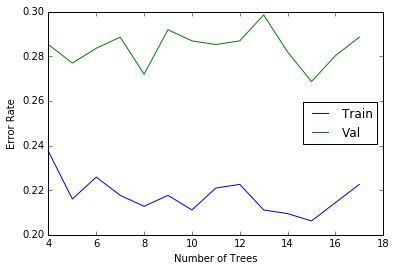

In [20]:
plt.plot(numTrees, err_tr_rf, label="Train")
plt.plot(numTrees, err_val_rf, label="Val")
plt.xlabel("Number of Trees")
plt.ylabel("Error Rate")
plt.legend(loc='best')

We see that the validation error rate is almost 5-10% higher than train error rate, indicating an overfit. We are using number of trees = 12 since it is the point where the train/validation error rates are closest.

Now let's test the model on the test dataset.

In [21]:
rf_test = RandomForestClassifier(labelCol='label', featuresCol='features', numTrees=12)
test_model = rf_test.fit(train_df)
test_pred = test_model.transform(test_df)
test_acc = evaluator_rf.evaluate(test_pred)
print "Test Error Rate = %g" % (1.0 - test_acc)

Test Error Rate = 0.280156


And now we have the test error rate of RF classifier with 12 trees.

### Classification using Multilayer Perceptrons

In [22]:
from pyspark.ml.classification import MultilayerPerceptronClassifier

various_layers = {'1':[5, 8, 6, 4], '2':[5, 16, 8, 4], '3':[5, 16, 4], '4': [5, 8, 4]}
numIter = [10, 20, 30, 40]
mlp_evaluator = MulticlassClassificationEvaluator(\
       labelCol="label", predictionCol="prediction",\
       metricName="precision")

tr_err_layers = {}
val_err_layers = {}

for k, v in various_layers.items():
    mlp_err_tr = []
    mlp_err_val = []
    for i in numIter:
        
        print "Layers: ", v
        print "Number of Iteration: %g" % i
        mlp = MultilayerPerceptronClassifier(\
                    maxIter=i, layers=v, blockSize=128,\
                    seed=123)
        mlp_model = mlp.fit(train_df)
        
        mlp_pred_tr = mlp_model.transform(train_df)
        acc_tr = mlp_evaluator.evaluate(mlp_pred_tr)
        err_tr = 1.0 - acc_tr
        mlp_err_tr.append(err_tr)
        print "Train Error Rate = %g" % err_tr
        
        mlp_pred_val = mlp_model.transform(val_df)
        acc_val = mlp_evaluator.evaluate(mlp_pred_val)
        err_val = 1.0 - acc_val
        mlp_err_val.append(err_val)
        print "Val Error Rate = %g" % err_val
    tr_err_layers[k] = mlp_err_tr
    val_err_layers[k] = mlp_err_val

print tr_err_layers
print val_err_layers

Layers:  [5, 8, 6, 4]
Number of Iteration: 10
Train Error Rate = 0.273322
Val Error Rate = 0.33665
Layers:  [5, 8, 6, 4]
Number of Iteration: 20
Train Error Rate = 0.276596
Val Error Rate = 0.3267
Layers:  [5, 8, 6, 4]
Number of Iteration: 30
Train Error Rate = 0.271686
Val Error Rate = 0.330017
Layers:  [5, 8, 6, 4]
Number of Iteration: 40
Train Error Rate = 0.243863
Val Error Rate = 0.283582
Layers:  [5, 16, 4]
Number of Iteration: 10
Train Error Rate = 0.283142
Val Error Rate = 0.333333
Layers:  [5, 16, 4]
Number of Iteration: 20
Train Error Rate = 0.235679
Val Error Rate = 0.296849
Layers:  [5, 16, 4]
Number of Iteration: 30
Train Error Rate = 0.220949
Val Error Rate = 0.278607
Layers:  [5, 16, 4]
Number of Iteration: 40
Train Error Rate = 0.204583
Val Error Rate = 0.280265
Layers:  [5, 16, 8, 4]
Number of Iteration: 10
Train Error Rate = 0.273322
Val Error Rate = 0.33665
Layers:  [5, 16, 8, 4]
Number of Iteration: 20
Train Error Rate = 0.268412
Val Error Rate = 0.308458
Layers:  [

We want to know the optimal number of iteration

In [23]:
tr_err_list = [v for k,v in tr_err_layers.items()]
val_err_list = [v for k,v in val_err_layers.items()]
lyrs = [v for k,v in various_layers.items()]
print tr_err_list
print val_err_list
print lyrs

[[0.2733224222585925, 0.276595744680851, 0.2716857610474632, 0.24386252045826518], [0.2831423895253683, 0.23567921440261863, 0.22094926350245503, 0.20458265139116205], [0.2733224222585925, 0.2684124386252046, 0.23567921440261863, 0.22094926350245503], [0.2733224222585925, 0.24058919803600654, 0.22094926350245503, 0.23076923076923073]]
[[0.33665008291873966, 0.3266998341625207, 0.3300165837479271, 0.28358208955223885], [0.33333333333333337, 0.296849087893864, 0.2786069651741293, 0.28026533996683245], [0.33665008291873966, 0.3084577114427861, 0.26865671641791045, 0.2703150912106136], [0.3349917081260365, 0.30679933665008297, 0.2819237147595357, 0.2786069651741293]]
[[5, 8, 6, 4], [5, 16, 4], [5, 16, 8, 4], [5, 8, 4]]


Now we plot the results to examine the best MLP model.

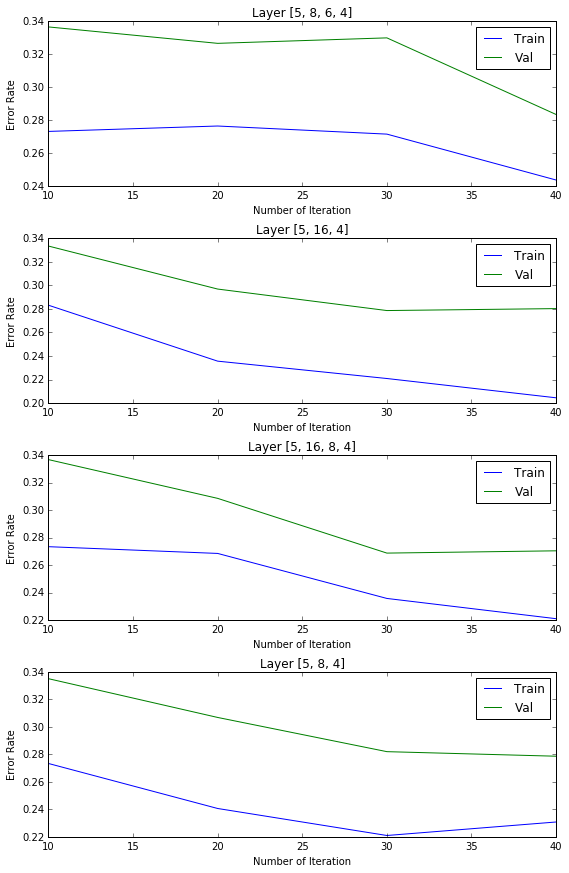

In [26]:
from pylab import rcParams

types = len(various_layers)
for i in range(types):
    plt.subplot(types, 1, (i+1))

    plt.plot(numIter, tr_err_list[i], label="Train")
    plt.plot(numIter, val_err_list[i], label="Val")

    plt.tight_layout()
    plt.rcParams["figure.figsize"] = (12, 16)
    plt.xlabel("Number of Iteration")
    plt.ylabel("Error Rate")
    plt.legend(loc='best')
    plt.title("Layer " + str(lyrs[i]))


From the plots, we see that MLP with layer variation [5, 16, 8, 4] generates lowest train and val error rates. Additionally, 40 iterations seem to produce the lowest, non-overfitting results.

In [27]:
# Create the model
maxIter = 40
layers = [5, 16, 8, 4]
mlp = MultilayerPerceptronClassifier(\
                    maxIter=maxIter, layers=layers, blockSize=128,\
                    seed=123)
# Train
test_mlp_model = mlp.fit(train_df)

# Start testing
test_mlp_pred = test_mlp_model.transform(test_df)

# Evaluate
test_mlp_acc = mlp_evaluator.evaluate(test_mlp_pred)
test_mlp_err = 1.0 - test_mlp_acc
print "MLP Test Error = %g" % test_mlp_err

MLP Test Error = 0.276265


Recall that Decision Tree test error is 0.285992 and Random Forest is 0.280156, making MLP test error the lowest with 0.276265.